In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [ ]:
supervised_data = pd.read_csv('/content/drive/MyDrive/output.csv')
# Load unsupervised datasets from JSONL files
unsupervised_train  = pd.read_json('/content/drive/MyDrive/webis-clickbait-22/train.jsonl', lines=True)
unsupervised_val  = pd.read_json('/content/drive/MyDrive/webis-clickbait-22/validation.jsonl', lines=True)

In [ ]:
# Separate features and labels
X = supervised_data[' title']  # Text data
y = supervised_data['label']  # Labels

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Tokenization and padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_seq, maxlen=100)
X_test_padded = pad_sequences(X_test_seq, maxlen=100)


In [ ]:
# Build the RNN model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model.add(SimpleRNN(64, return_sequences=True))
model.add(SimpleRNN(64))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 128)          640000    
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 100, 64)           12352     
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 660673 (2.52 MB)
Trainable params: 660673 (2.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the RNN model with validation data
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5
720/720 [==============================] - 48s 62ms/step - loss: 0.1326 - accuracy: 0.9450 - val_loss: 0.0774 - val_accuracy: 0.9723
Epoch 2/5
720/720 [==============================] - 45s 63ms/step - loss: 0.0383 - accuracy: 0.9870 - val_loss: 0.2003 - val_accuracy: 0.9218
Epoch 3/5
720/720 [==============================] - 45s 62ms/step - loss: 0.0310 - accuracy: 0.9896 - val_loss: 0.1023 - val_accuracy: 0.9680
Epoch 4/5
720/720 [==============================] - 44s 61ms/step - loss: 0.0084 - accuracy: 0.9974 - val_loss: 0.1172 - val_accuracy: 0.9664
Epoch 5/5
720/720 [==============================] - 45s 62ms/step - loss: 0.0232 - accuracy: 0.9914 - val_loss: 0.1226 - val_accuracy: 0.9676


In [ ]:
# Evaluate the RNN model on the test set
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test accuracy: {test_accuracy}")

200/200 [==============================] - 3s 13ms/step - loss: 0.1159 - accuracy: 0.9697
Test accuracy: 0.9696780443191528


In [ ]:
# Predict on the test set
y_test_pred_probs = model.predict(X_test_padded)
y_test_pred = (y_test_pred_probs > 0.5).astype(int).flatten()

200/200 [==============================] - 3s 13ms/step


In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

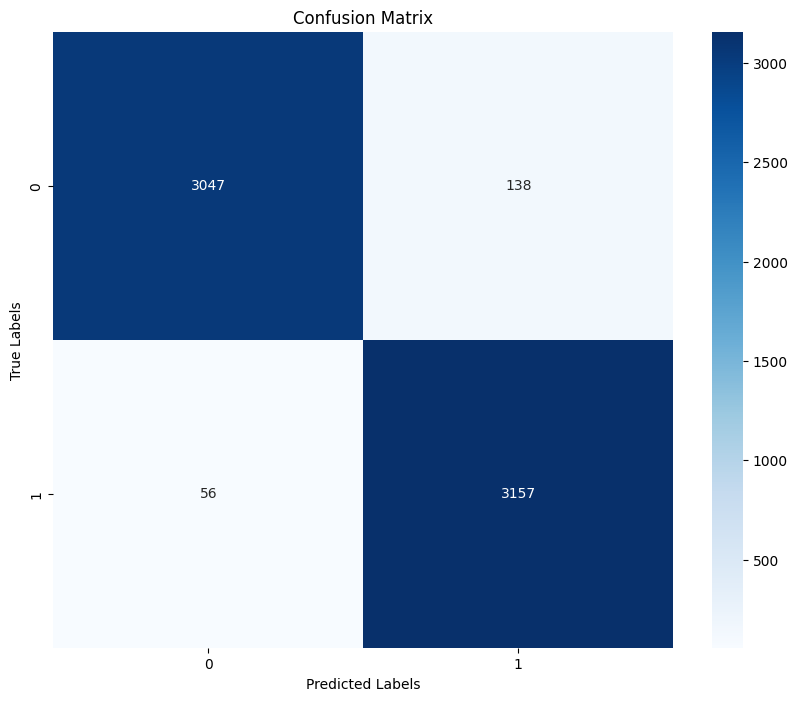

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Extract relevant text features from the unsupervised datasets
X_unlabeled_train = unsupervised_train['postText'].astype(str)
X_unlabeled_val = unsupervised_val['postText'].astype(str)


In [ ]:
# Tokenize and pad the unsupervised data
X_unlabeled_train_seq = tokenizer.texts_to_sequences(X_unlabeled_train)
X_unlabeled_val_seq = tokenizer.texts_to_sequences(X_unlabeled_val)
X_unlabeled_train_padded = pad_sequences(X_unlabeled_train_seq, maxlen=100)
X_unlabeled_val_padded = pad_sequences(X_unlabeled_val_seq, maxlen=100)

In [ ]:
# Predict pseudo-labels for the unsupervised training data
pseudo_labels_train_probs = model.predict(X_unlabeled_train_padded)
pseudo_labels_train = (pseudo_labels_train_probs > 0.5).astype(int).flatten()

100/100 [==============================] - 2s 21ms/step


In [ ]:
# Select high-confidence samples for self-training
confidence_threshold = 0.8
high_confidence_idx_train = pseudo_labels_train_probs.flatten() >= confidence_threshold

Epoch 1/5
392/392 [==============================] - 30s 76ms/step - loss: 0.0151 - accuracy: 0.9956 - val_loss: 0.1890 - val_accuracy: 0.9184
Epoch 2/5
392/392 [==============================] - 30s 76ms/step - loss: 0.0031 - accuracy: 0.9992 - val_loss: 0.1416 - val_accuracy: 0.9490
Epoch 3/5
392/392 [==============================] - 30s 77ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.1050 - val_accuracy: 0.9659
Epoch 4/5
392/392 [==============================] - 30s 77ms/step - loss: 7.8317e-04 - accuracy: 0.9998 - val_loss: 0.2371 - val_accuracy: 0.9292
Epoch 5/5
200/200 [==============================] - 3s 13ms/step - loss: 0.1418 - accuracy: 0.9712
Test accuracy after self-training: 0.9712409973144531


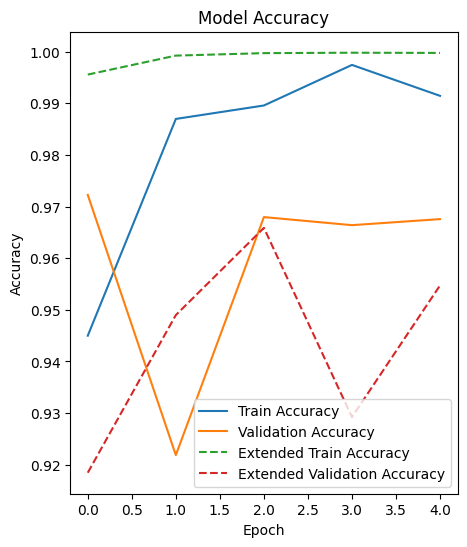

In [ ]:
# Create a new training set with high-confidence pseudo-labels
if np.any(high_confidence_idx_train):
    X_train_extended = np.vstack((X_train_padded, X_unlabeled_train_padded[high_confidence_idx_train]))
    y_train_extended = np.hstack((y_train, pseudo_labels_train[high_confidence_idx_train]))

    # Retrain the model with the extended dataset
    history_extended = model.fit(X_train_extended, y_train_extended, epochs=5, batch_size=64, validation_split=0.1)

    # Predict pseudo-labels for the unsupervised validation data
    pseudo_labels_val_probs = model.predict(X_unlabeled_val_padded)
    pseudo_labels_val = (pseudo_labels_val_probs > 0.5).astype(int).flatten()
    high_confidence_idx_val = pseudo_labels_val_probs.flatten() >= confidence_threshold

    # Evaluate the updated model on the test set
    test_loss_updated, test_accuracy_updated = model.evaluate(X_test_padded, y_test)
    print(f"Test accuracy after self-training: {test_accuracy_updated}")

    # Plot training & validation accuracy
    plt.figure(figsize=(5, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    if 'accuracy' in history_extended.history:
        plt.plot(history_extended.history['accuracy'], label='Extended Train Accuracy', linestyle='--')
        plt.plot(history_extended.history['val_accuracy'], label='Extended Validation Accuracy', linestyle='--')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
else:
    print("No high-confidence samples available for self-training.")